## Simulation Verification

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [42]:
import logging
import os
from collections import OrderedDict

import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_context('notebook')

from agnfinder import simulation_samples, simulation_utils

In [3]:
os.chdir('/home/mike/repos/agnfinder')
grid_loc = 'data/photometry_simulation_100000.hdf5'

In [4]:
assert os.path.isfile(grid_loc)
with h5py.File(grid_loc, 'r') as f:
    param_names = f['samples']['theta'].attrs['columns']  # stored as "attribute" metadata
    norm_theta = f['samples']['normalised_theta'][...]
    theta = f['samples']['theta'][...]
    simulated_y = f['samples']['simulated_y'][...]
    wavelengths = f['samples']['wavelengths'][...]

## Visualise theta vs normalised theta

In [5]:
param_names

array(['log_mass', 'dust2', 'tage', 'log_tau', 'log_agn_mass', 'agn_eb_v',
       'log_agn_torus_mass'], dtype=object)

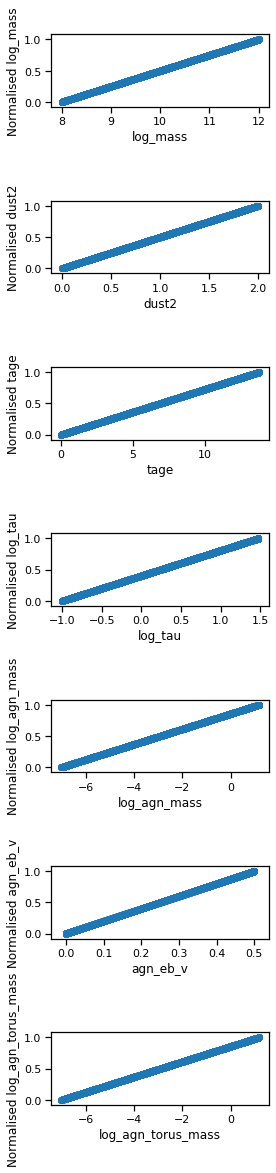

In [6]:
fig, axes = plt.subplots(nrows=len(param_names), figsize=(4, 16))
for param_n, param_name in enumerate(param_names):
    if param_name.startswith('log'):
        theta_to_plot = np.log10(theta)
    else:
        theta_to_plot = theta
    ax = axes[param_n]
    ax.scatter(theta_to_plot[:, param_n], norm_theta[:, param_n], alpha=0.03)
    ax.set_xlabel(param_name)
    ax.set_ylabel(f'Normalised {param_name}')
fig.tight_layout()

## Visualise photometry in grid along each param

In [7]:
wavelengths  # in angstroms

array([ 3545.9515156 ,  4669.6375124 ,  6156.34362463,  7470.59215536,
        8917.58185532, 16397.13029184, 12513.8266968 , 21392.23213854,
       10205.12640526,  8801.6644194 , 33461.019081  , 45952.08900757])

#### Random selection of galaxies

In [8]:
n_traces = 100

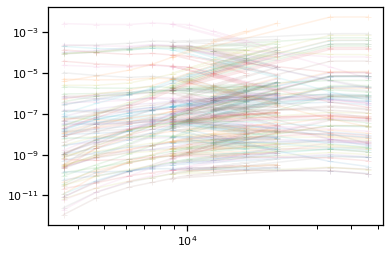

In [9]:
fig, ax = plt.subplots()
selected_indices = np.random.choice(np.arange(len(simulated_y)), size=n_traces)
selected_photometry = simulated_y[selected_indices]
for n in range(n_traces):  # first n
    ax.loglog(wavelengths, selected_photometry[n], marker='+', alpha=0.1)


### Coloring by one parameter

In [30]:
selection_mask = (theta[:, 4] < 10 ** -2) & (theta[:, 6] < 10 ** -2)  # only galaxies without AGN
theta_selected = theta[selection_mask]
norm_theta_selected = norm_theta[selection_mask]
photometry_selected = simulated_y[selection_mask]

In [31]:
n_traces = 100
param_n = 0
sample_indices = np.random.choice(np.array(range(len(theta_selected))), size=n_traces)

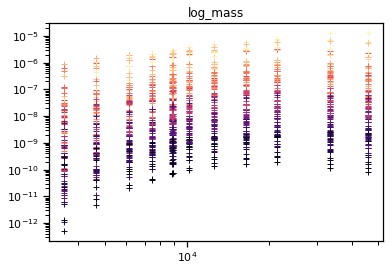

In [32]:
fig, ax = plt.subplots()
param_n = 0  # log mass
for n in range(n_traces):
    ax.loglog(wavelengths, photometry_selected[n], marker='+', color=cm.magma(norm_theta_selected[n, param_n]), linestyle='')
    ax.set_title(param_names[param_n])

In [33]:
# selection_mask = (norm_theta_selected[:, 0] > 0.4) & (norm_theta_selected[:, 0] < 0.6)  # fix the mass
# photometry_fixed_mass = photometry_selected[selection_mask]
# theta_fixed_mass = theta_selected[selection_mask]
# norm_theta_fixed_mass = norm_theta_selected[selection_mask]

In [34]:
# n_galaxy_params = 4
# fig, axes = plt.subplots(nrows=n_galaxy_params-1, figsize=(6, 14))
# n_traces = 10
# for param_n in range(1, n_galaxy_params):
#     for n in range(n_traces):
#         ax = axes[param_n-1]
#         ax.loglog(wavelengths, photometry_fixed_mass[n], marker='+', color=cm.magma(norm_theta_fixed_mass[n, param_n]), linestyle='')
#         ax.set_title(param_names[param_n])
# fig.tight_layout()

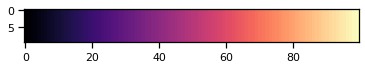

In [35]:
plt.imshow([np.linspace(0, 1, 100) for n in range(10)], cmap=cm.magma)
# plt.xticks(np.linspace(0, 1, 100))

3835
366
35
3699
350
29
3699
378
39
3699
378
37


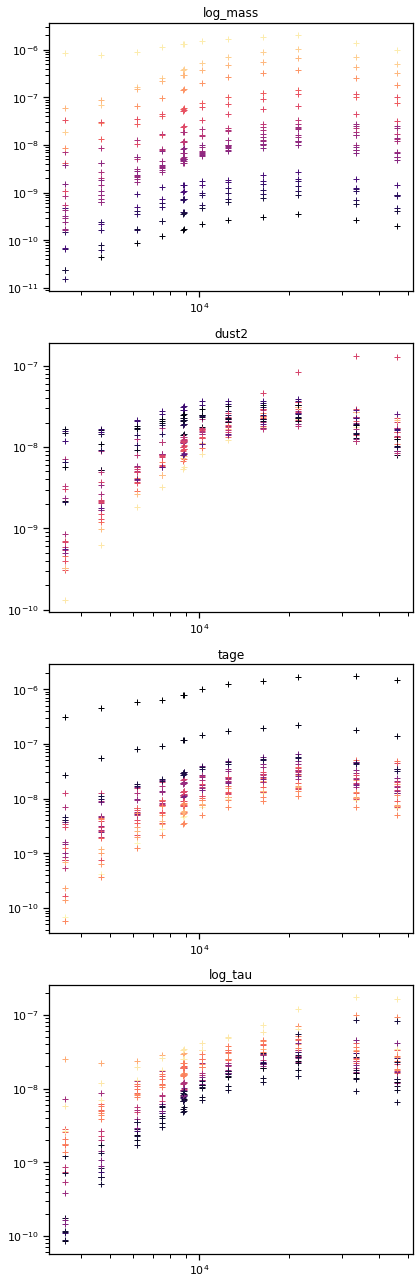

In [41]:
# really though, we want to fix *everything else*
n_galaxy_params = 4
fig, axes = plt.subplots(nrows=n_galaxy_params, figsize=(6, 18))
n_traces = 25
for param_n in range(n_galaxy_params):
    selection_mask = np.ones(len(photometry_selected)).astype(bool)
    for n in range(n_galaxy_params):
        if n is not param_n:
            new_filter = np.array([(norm_theta_selected[:, n] > 0.45) & (norm_theta_selected[:, n] < 0.55)]).squeeze()
            selection_mask = selection_mask & new_filter
            print(selection_mask.sum())
    assert selection_mask.any()
    photometry_else_fixed = photometry_selected[selection_mask]
    norm_theta_else_fixed = norm_theta_selected[selection_mask]
    for n in range(min(n_traces, len(photometry_else_fixed))):
        ax = axes[param_n]
        ax.loglog(wavelengths, photometry_else_fixed[n], marker='+', color=cm.magma(norm_theta_else_fixed[n, param_n]), linestyle='')
        ax.set_title(param_names[param_n])
    fig.tight_layout()

In [ ]:
assert False

In [ ]:
galaxy_index = 10

In [ ]:
direct_simulator, wavelengths = simulation_samples.get_photometry_simulator(
        emulate_ssp=True,
        noise=True)

In [ ]:
direct_photometry = direct_simulator(theta[galaxy_index])

In [ ]:
wavelengths

In [ ]:
sims = np.array([simulated_y[n] for n in range(100)])
assert np.argmin(np.sum(np.abs(sims - direct_photometry), axis=1)) == galaxy_index

In [ ]:
plt.loglog(wavelengths, sims[galaxy_index], 'x', label='stored')
plt.loglog(wavelengths, direct_photometry, 'x', label='recovered')
plt.legend() # also matches indirect (i.e. via normalisasimulate(args.n_samples, save_loc, args.emulate_ssp, args.noise)tion)

In [ ]:
limits = OrderedDict({
            'log_mass': [8, 12], 
            'dust2': [0.001, 13.8],
            'tage': [0., 2.],
            'tau': [.1, 30],
            'log_agn_mass': [-7, np.log10(15)],
            'agn_eb_v': [0., 0.5],
            'log_agn_torus_mass': [-7, np.log10(15)]
        })

simulation_utils.denormalise_theta(norm_theta[0], limits)

In [ ]:
problem = main.load_simulator(emulate_ssp=True, noise=False)

In [ ]:
10 ** problem.simulator(norm_theta[0])